In [1]:
import os
import sys
sys.path.append('..')

import numpy as np

from data_loader.load_data import ImagesLoader
from data_loader.colors import Colors
from simpsons_classifier import SimpsonsClassifier
from voter import Voter as vote
from challenge.simpsons import *
import load_stacking_models as stack

from sklearn.metrics import classification_report, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
print(sys.version)
print(sys.version_info)

3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)


In [3]:
# selecionando os dados desejados

DATASET_NAME = 'simpsons-small-balanced'

FIELDS = [
    'images_hsv',
    'images_h',
    'images_s',
    'images_v',
    'descriptor_h',
    'descriptor_s',
    'descriptor_v',
    'descriptor_hsv',
    'descriptor_hu',
    'descriptor_lbp',
    'combination_hsv+hu',
    'combination_hsv+lbp+hu'
]

In [4]:
# carregando os dados

loader = ImagesLoader(train_images_path=f'../data/{DATASET_NAME}/train/',
                      test_images_path=f'../data/{DATASET_NAME}/test/')

data = loader.load_data(load_list=FIELDS)

+ 'names_files' loaded
+ 'names_paths' loaded
+ 'names_characters' loaded
+ 'names_encoded' loaded
+ 'images_original' loaded
+ 'images_resized' loaded
+ 'images_gray' loaded
- 'images_blue' not in load list
- 'images_green' not in load list
- 'images_red' not in load list
+ 'images_hsv' loaded
+ 'images_h' loaded
+ 'images_s' loaded
+ 'images_v' loaded
- 'images_lbp' not in load list
- 'images_hu' not in load list
- 'images_gabor' not in load list
- 'images_hog' not in load list
- 'descriptor_blue' not in load list
- 'descriptor_green' not in load list
- 'descriptor_red' not in load list
- 'descriptor_rgb' not in load list
+ 'descriptor_h' loaded
+ 'descriptor_s' loaded
+ 'descriptor_v' loaded
+ 'descriptor_hsv' loaded
+ 'descriptor_lbp' loaded
+ 'descriptor_hu' loaded
- 'descriptor_gabor' not in load list
- 'descriptor_hog' not in load list
- 'combination_rgb+hsv' not in load list
- 'combination_rgb+hsv+lbp' not in load list
- 'combination_rgb+hsv+hu' not in load list
- 'combination_

In [5]:
# shape dos dados

print('names_characters')
print(np.array(data['names_characters']['train']).shape,
      np.array(data['names_characters']['test']).shape, end='\n\n')

for field in ['descriptor_lbp',
              'combination_hsv+hu',
              'combination_hsv+lbp+hu']:
      print(f'{field} shape =',
            np.array(data[field]['train']).shape,
            np.array(data[field]['test']).shape)

names_characters
(324,) (95,)

descriptor_lbp shape = (324, 10) (95, 10)
combination_hsv+hu shape = (324, 775) (95, 775)
combination_hsv+lbp+hu shape = (324, 785) (95, 785)


In [6]:
# os arquivos carregados pela função 'load_data'
# são os mesmos de 'train.txt' e 'test.txt'?

# carregando os dados dos txts

X_train_files, y_train_files = load_train_data('../challenge/train.txt')
X_test_files, y_test_files = load_test_data('../challenge/test.txt')

print(X_train_files.shape, y_train_files.shape)
print(X_test_files.shape, y_test_files.shape)

(324,) (324,)
(95,) (95,)


In [7]:
X_train_files[:5]

array(['../data/simpsons-small-balanced/train/bart0007.jpg',
       '../data/simpsons-small-balanced/train/bart001.bmp',
       '../data/simpsons-small-balanced/train/bart0012.jpg',
       '../data/simpsons-small-balanced/train/bart002.bmp',
       '../data/simpsons-small-balanced/train/bart0022.jpg'], dtype='<U51')

In [8]:
y_train_files[:5]

array([0, 0, 0, 0, 0])

In [9]:
# os dados carregados dos arquivos são iguais aos
# carregados pela função

print(all(data['names_paths']['train'] == X_train_files))
print(all(data['names_paths']['test'] == X_test_files))

print(all(data['names_encoded']['train'] == y_train_files))
print(all(data['names_encoded']['test'] == y_test_files))

True
True
True
True


In [33]:
# existe alguma imagem de teste em treino?

for train_img in data['images_gray']['train']:
    for test_img in data['images_gray']['test']:
        if all(train_img.ravel() == test_img.ravel()):
            print(train_img)

In [10]:
# train-test split

X_train = [
    data['combination_hsv+hu']['train'],
    data['combination_hsv+lbp+hu']['train'],
    data['descriptor_hsv']['train'],
]

y_train = data['names_encoded']['train']

X_test = [
    data['combination_hsv+hu']['test'],
    data['combination_hsv+lbp+hu']['test'],
    data['descriptor_hsv']['test'],
]

y_test = data['names_encoded']['test']

In [11]:
# carregando modelos instanciados

stacks = stack.load_stacking_models(load_type='memory')

# cada campo representa uma stack
list(stacks.keys())

['combination_hsv+hu', 'combination_hsv+lbp+hu', 'descriptor_hsv']

In [12]:
# criação e treinamento do modelo

simp = SimpsonsClassifier(stack_models=stacks)
simp.fit(X_train, y_train)
preds = simp.predict(X_test)

In [13]:
# predições do modelo; cada campo
# representa as predições de uma stack

list(preds.keys())

['combination_hsv+hu', 'combination_hsv+lbp+hu', 'descriptor_hsv']

In [14]:
# realizando uma votação entre as três
# listas de predições distintas de cada stack

# pesos para cada campo e cada classe
weights = [[1, 1, 1],
           [1, 1, 1],
           [1, 1, 1],
           [3, 3, 3],
           [4, 4, 4]]

y_pred = vote.hard_voting(list(preds.values()),
                          weights=weights)

y_pred

array([3, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 0, 0, 1,
       0, 2, 2, 1, 3, 2, 2, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 0, 0, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3])

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        35
           1       0.81      0.84      0.82        25
           2       0.86      0.46      0.60        13
           3       0.82      0.90      0.86        10
           4       0.90      0.75      0.82        12

    accuracy                           0.81        95
   macro avg       0.83      0.77      0.79        95
weighted avg       0.82      0.81      0.80        95



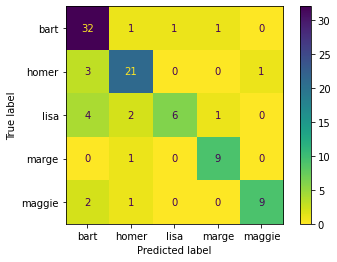

In [15]:
# resultados

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=loader.labels)
cm_plot.plot(cmap='viridis_r');

In [16]:
# lendo o arquivo de predições
# e conferindo os resultados

with open('../challenge/predictions.txt', 'r') as f:
    fpreds = f.read()
    fpreds = fpreds.strip()
    fpreds = fpreds.split('\n')
    fpreds = np.array([int(i.split(' ')[1]) for i in fpreds])

fpreds

array([3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0, 0, 1,
       0, 2, 2, 1, 3, 2, 2, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 0, 0, 4, 3, 3,
       3, 3, 1, 3, 3, 1, 3])

In [17]:
# as predições geradas são iguais às do arquivo txt?

print(all(y_pred == fpreds))
y_pred == fpreds

False


array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True])

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        35
           1       0.75      0.84      0.79        25
           2       1.00      0.38      0.56        13
           3       0.78      0.70      0.74        10
           4       0.82      0.75      0.78        12

    accuracy                           0.79        95
   macro avg       0.83      0.72      0.74        95
weighted avg       0.81      0.79      0.78        95



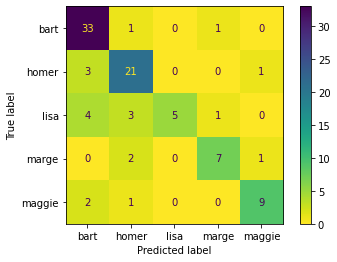

In [18]:
print(classification_report(y_test, fpreds))

cm = confusion_matrix(y_test, fpreds)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=loader.labels)
cm_plot.plot(cmap='viridis_r');